Add noise
Nguyen Viet Hoang 
Các noise model tác động lên chất lượng ảnh


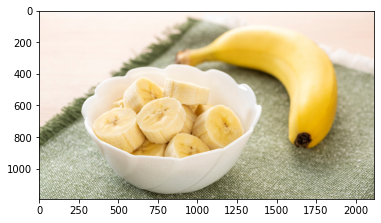

In [2]:
from add_noise import GaussianNoise
import cv2
from config import Flag
import matplotlib.pyplot as plt


prefix = Flag.image_origin
file_name = prefix / 'banana.jpg'
image = cv2.imread(str(file_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()



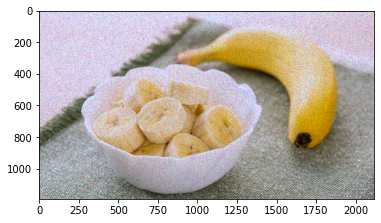

In [7]:
from add_noise import SaltAndPeperNoise

saltAndPeperNoise = SaltAndPeperNoise(str(file_name), s_vs_p=1, amount=0.1)
sapn = saltAndPeperNoise.noise()
# print(sapn)
image_noise = sapn
plt.imshow(sapn)
# plt.show()

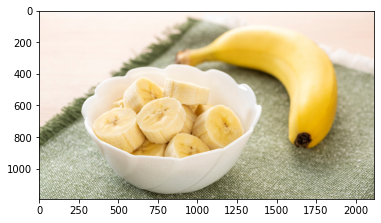

TypeError: descriptor 'uniform' for 'numpy.random._generator.Generator' objects doesn't apply to a 'float' object

In [5]:
from add_noise import UniformNoise
uni_noise = UniformNoise(filepath=file_name)
noise_image = image+uni_noise.noise()
plt.imshow(noise_image)

